In [2]:

import torch
import torch.nn as nn
from torch.nn import TransformerEncoder, TransformerEncoderLayer

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer

# Define the TransformerEncoderModel
class TransformerEncoderModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_heads):
        super(TransformerEncoderModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.embedding = nn.Linear(input_dim, hidden_dim)
        encoder_layers = TransformerEncoderLayer(hidden_dim, num_heads)
        self.transformer_encoder = TransformerEncoder(encoder_layers, num_layers)
        
    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(1, 0, 2)  # Reshape to (seq_len, batch_size, hidden_dim)
        output = self.transformer_encoder(x)
        output = output.permute(1, 0, 2)  # Reshape back to (batch_size, seq_len, hidden_dim)
        return output

# Example usage
input_dim = 10  # Dimension of each time step in the time series
hidden_dim = 64  # Hidden dimension of the transformer
num_layers = 6  # Number of transformer encoder layers
num_heads = 8  # Number of attention heads

# Create an instance of the TransformerEncoderModel
model = TransformerEncoderModel(input_dim, hidden_dim, num_layers, num_heads)

# Generate some dummy time series data
batch_size = 16
seq_len = 100
time_series = torch.randn(batch_size, seq_len, input_dim)

# Pass the time series through the transformer encoder
encoded_time_series = model(time_series)    # shape (batch_size, seq_len, hidden_dim)


In [36]:
encoded_time_series.shape

torch.Size([16, 100, 64])

---

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer

# Define the TransformerEncoderModel
class TransformerEncoderModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_heads):
        super(TransformerEncoderModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.embedding = nn.Linear(input_dim, hidden_dim)
        encoder_layers = TransformerEncoderLayer(hidden_dim, num_heads)
        self.transformer_encoder = TransformerEncoder(encoder_layers, num_layers)
        
    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(1, 0, 2)  # Reshape to (seq_len, batch_size, hidden_dim)
        output = self.transformer_encoder(x)
        output = output.permute(1, 0, 2)  # Reshape back to (batch_size, seq_len, hidden_dim)
        return output
    

# Define the full model
class TimeSeriesEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_heads):
        super(TimeSeriesEncoder, self).__init__()
        self.encoder_layer = TransformerEncoderModel(input_dim, hidden_dim, num_layers, num_heads)
        self.fc1 = nn.Linear(hidden_dim*100,256)
        self.fc2 = nn.Linear(256,256)
        self.fc3 = nn.Linear(256,10)
        self.relu = nn.ReLU()
    
        
    def forward(self, x):
        # x: [seq_len, batch_size, input_size]
        encoding = self.encoder_layer(x)
        # encoding: [seq_len, batch_size, hidden_size]
        encoding = encoding.reshape(encoding.shape[0],-1)

        encoding = self.fc1(encoding)
        encoding = self.relu(encoding)
        
        encoding = self.fc2(encoding)
        encoding = self.relu(encoding)
        
        encoding = self.fc3(encoding)


        return encoding


# Example usage
input_dim = 5  # Dimension of each time step in the time series
hidden_dim = 64  # Hidden dimension of the transformer
num_layers = 3  # Number of transformer encoder layers
num_heads = 8  # Number of attention heads


model = TimeSeriesEncoder(input_dim, hidden_dim, num_layers, num_heads).to(device=device)


# Generate some dummy time series data
batch_size = 16
seq_len = 100
time_series = torch.randn(batch_size, seq_len, input_dim).to(device=device)

# Pass the time series through the transformer encoder
encoded_time_series = model(time_series)    # shape (batch_size, seq_len, hidden_dim)


In [12]:
encoded_time_series.shape

torch.Size([16, 10])

Prepare dataset:

In [14]:
ratio = 'BTC-USD'
dataset = f'crypto_data/{ratio}.csv' 
data = pd.read_csv(dataset, names=['time', 'low', 'high', 'open', 'close', 'volume'])  # read in specific file


In [15]:
import pandas as pd
import numpy as np

# Normalize the data
data = (data - data.mean()) / data.std()

# Convert the DataFrame to a Torch tensor
data_tensor = torch.from_numpy(data.values).float()

# Split the data into input and target sequences
input_seq = []
target_seq = []
seq_length = 100
pred_length = 10

for i in range(len(data) - seq_length - pred_length):
    input_seq.append(data_tensor[i:i+seq_length, 1:])
    target_seq.append(data_tensor[i+seq_length:i+seq_length+pred_length, -2])

target $\rightarrow$ close

In [16]:
input_seq[0].shape , len(input_seq)

(torch.Size([100, 5]), 97614)

In [17]:
target_seq[0].shape

torch.Size([10])

In [18]:
input_seq = torch.stack(input_seq)
target_seq = torch.stack(target_seq)

In [19]:
input_seq.shape , target_seq.shape

(torch.Size([97614, 100, 5]), torch.Size([97614, 10]))

 Define the loss function and the optimizer :


In [22]:
num_epochs = 100
learning_rate = 0.001

batch_size = 32  # Set your desired batch size

In [24]:

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

 Train the model :


In [25]:
from torch.utils.data import DataLoader,Dataset
from tqdm import tqdm


define `DataLoader` :

In [26]:
class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [27]:
dataset = StockDataset(input_seq, target_seq)

In [28]:
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [29]:
for batch_idx, (data, targets) in enumerate(tqdm(dataloader)):
    print(targets.shape, "   <<>>   ",data.shape)
    
    if batch_idx == 10:
        break
    

  0%|          | 10/3051 [00:00<00:04, 613.53it/s]

torch.Size([32, 10])    <<>>    torch.Size([32, 100, 5])
torch.Size([32, 10])    <<>>    torch.Size([32, 100, 5])
torch.Size([32, 10])    <<>>    torch.Size([32, 100, 5])
torch.Size([32, 10])    <<>>    torch.Size([32, 100, 5])
torch.Size([32, 10])    <<>>    torch.Size([32, 100, 5])
torch.Size([32, 10])    <<>>    torch.Size([32, 100, 5])
torch.Size([32, 10])    <<>>    torch.Size([32, 100, 5])
torch.Size([32, 10])    <<>>    torch.Size([32, 100, 5])
torch.Size([32, 10])    <<>>    torch.Size([32, 100, 5])
torch.Size([32, 10])    <<>>    torch.Size([32, 100, 5])
torch.Size([32, 10])    <<>>    torch.Size([32, 100, 5])


In [32]:
model(torch.rand(32,100,5).to(device=device)).unsqueeze(-1).shape

torch.Size([32, 10, 1])

In [33]:
# Train Network
for epoch in range(num_epochs):
    # losses = []

    for batch_idx, (data, targets) in enumerate(tqdm(dataloader)):
        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)

        # forward
        scores = model(data).unsqueeze(-1)
        #print(scores.shape,"************",targets.unsqueeze(2).shape)
        loss = criterion(scores, targets.unsqueeze(2))

        #losses.append(loss.item())
        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()

    if (epoch+1) % 10 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))  # incorrect

100%|██████████| 3051/3051 [00:53<00:00, 56.94it/s]


Epoch [10/100], Loss: 0.0002


100%|██████████| 3051/3051 [00:48<00:00, 62.73it/s]


Epoch [20/100], Loss: 0.0006


100%|██████████| 3051/3051 [00:48<00:00, 63.25it/s]


Epoch [30/100], Loss: 0.0003


100%|██████████| 3051/3051 [00:48<00:00, 63.20it/s]


Epoch [40/100], Loss: 0.0003


100%|██████████| 3051/3051 [00:57<00:00, 52.80it/s]


Epoch [50/100], Loss: 0.0011


100%|██████████| 3051/3051 [00:47<00:00, 64.69it/s]


Epoch [60/100], Loss: 0.0004


100%|██████████| 3051/3051 [00:49<00:00, 62.15it/s]


Epoch [70/100], Loss: 0.0006


100%|██████████| 3051/3051 [00:49<00:00, 62.17it/s]


Epoch [80/100], Loss: 0.0003


100%|██████████| 3051/3051 [00:50<00:00, 60.44it/s]


Epoch [90/100], Loss: 0.0007


100%|██████████| 3051/3051 [00:49<00:00, 62.01it/s]


Epoch [100/100], Loss: 0.0006


# Evaluation :

In [35]:
ratio = 'BTC-USD'
dataset = f'crypto_data/{ratio}.csv' 
data = pd.read_csv(dataset, names=['time', 'low', 'high', 'open', 'close', 'volume']) 
data = (data - data.mean()) / data.std()


test 1:

In [46]:
def plot_resualt(start_index):
    test_input = data.loc[start_index:start_index+99]
    test_target = data.loc[start_index+99:start_index+99+9]
    output = torch.tensor(test_target.values)[:,-2].to(device=device)
    input = torch.tensor(test_input.values[:,1:],dtype=torch.float).unsqueeze(0).to(device=device)
    pred = model(input)

    pred_ = torch.Tensor.detach(torch.Tensor.cpu(pred.view(-1))).numpy()
    output_ = torch.Tensor.detach(torch.Tensor.cpu(output.view(-1))).numpy()

    sns.lineplot(pred_,marker='o')
    sns.lineplot(output_,color='r',marker='o')
    plt.legend(['close prediction','Truth']);

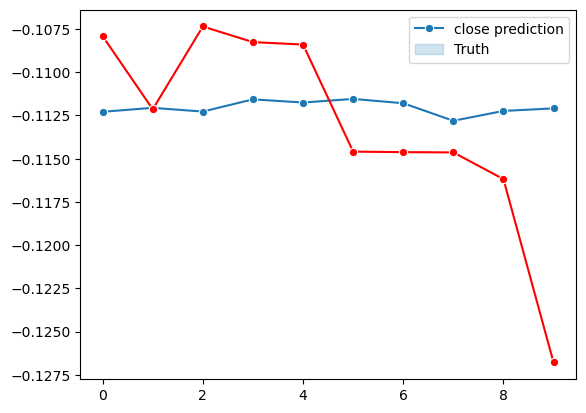

In [84]:
plot_resualt(96610)